# Preprocessing Data & DistilBERT Model Pipeline

In [ ]:
import os
import pandas as pd
from transformers import pipeline

# Input and output directories
input_dir = "usc-x-24-us-election-main"  # Replace with your main directory
output_file = "tweets_with_sentiment_analysis.csv"  # Output consolidated CSV file

# Load pre-trained sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

# Function to clean text
def clean_text(text):
    import re
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    # Remove mentions and hashtags
    text = re.sub(r"@\w+|#\w+", "", text)
    # Remove special characters, emojis, and numbers
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    # Convert to lowercase and strip extra spaces
    text = text.lower().strip()
    return text

# Function to process a single file
def process_file(file_path):
    processed_tweets = []
    df = pd.read_csv(file_path, compression="gzip")  # Load entire file
    for _, row in df.iterrows():
        try:
            # Skip non-English tweets or rows without text
            if pd.isnull(row["text"]) or row.get("lang") != "en":
                continue
            
            # Clean the text
            clean_tweet_text = clean_text(row["text"])
            
            # Skip empty or very short tweets after cleaning
            if len(clean_tweet_text) < 3:
                continue
            
            # Analyze sentiment
            sentiment = sentiment_analyzer(clean_tweet_text)[0]
            
            # Append processed tweet
            processed_tweets.append({
                "id": row["id"],
                "text": clean_tweet_text,
                "lang": row["lang"],
                "retweetCount": row.get("retweetCount", 0),
                "likeCount": row.get("likeCount", 0),
                "hashtags": row.get("hashtags", ""),
                "mentionedUsers": row.get("mentionedUsers", ""),
                "sentiment_label": sentiment["label"],  # e.g., POSITIVE, NEGATIVE
                "sentiment_score": sentiment["score"],  # Confidence score
            })
        except Exception as e:
            continue
    return processed_tweets

# Iterate over subdirectories
count = 10
for subdir in os.listdir(input_dir):
    if count % 10 == 0:
        subdir_path = os.path.join(input_dir, subdir)
        if os.path.isdir(subdir_path):  # Check if it's a directory
            print(f"Processing subdirectory: {subdir_path}")

            # Iterate over .csv.gz files in the subdirectory
            for file in os.listdir(subdir_path):
                if file.endswith(".csv.gz"):  # Process only .csv.gz files
                    file_path = os.path.join(subdir_path, file)
                    print(f"Processing file: {file_path}")

                    # Process the entire file
                    processed = process_file(file_path)

                    # Save processed data incrementally
                    pd.DataFrame(processed).to_csv(output_file, mode="a", index=False, header=not os.path.exists(output_file))
                    break
    count += 1

# Sentiment Distribution - Bar Chart

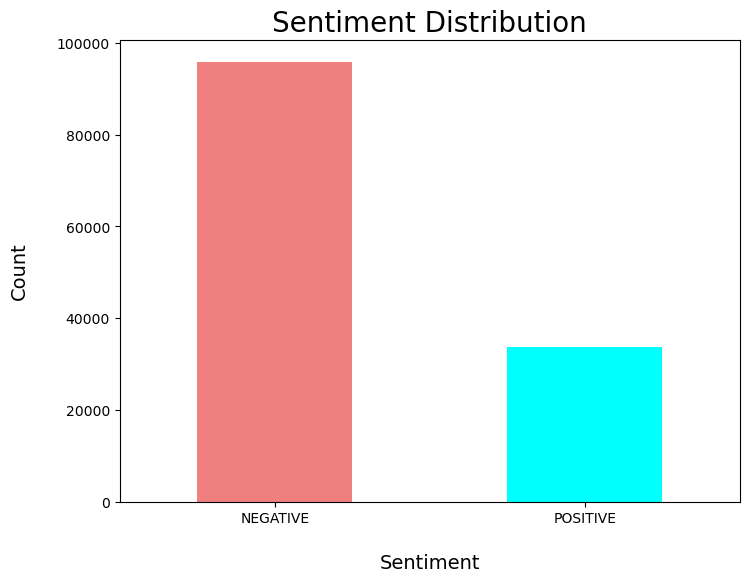

In [11]:
import pandas as pd 
import matplotlib.pyplot as plt
df = pd.read_csv("tweets_with_sentiment_analysis.csv")
sentiment_column = df.iloc[:, 7]  # Access the 8th column
sentiment_counts = sentiment_column.value_counts()
colors = []
for sentiment in sentiment_counts.index:
    if sentiment.upper() == 'POSITIVE':
        colors.append('cyan')
    else:
        colors.append('lightcoral')

sentiment_counts.plot(kind='bar', figsize=(8, 6), color=colors)
plt.title("Sentiment Distribution", fontsize=20)
plt.xlabel("Sentiment", fontsize=14, labelpad=20)
plt.xticks(rotation=0)
plt.ylabel("Count", fontsize=14, labelpad=20)
plt.show()

# Sentiment Distribution for Top Mentioned Users

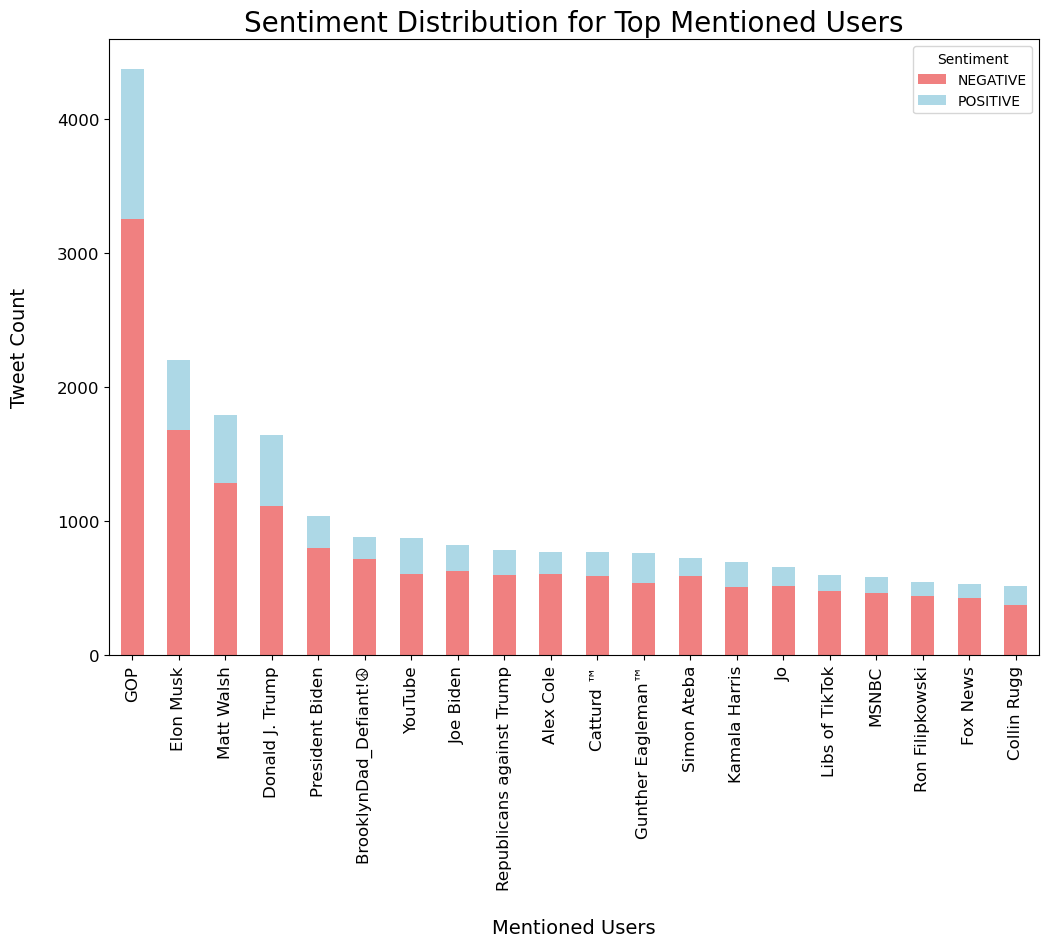

In [14]:
import pandas as pd
import ast  # To safely evaluate stringified lists/maps
import matplotlib.pyplot as plt

# Load your DataFrame
df = pd.read_csv("tweets_with_sentiment_analysis.csv")

# Map the columns by position
df['mentionedUsers'] = df.iloc[:, 6]  # Column 7 (index 6)
df['sentiment_label'] = df.iloc[:, 7]  # Column 8 (index 7)

# Convert the mentionedUsers column to a list of dictionaries
df['mentionedUsers'] = df['mentionedUsers'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) else [])

# Extract the 'name' field from each dictionary
df['mentionedUsers'] = df['mentionedUsers'].apply(lambda x: [user['name'] for user in x])

# Explode the mentionedUsers column
df_exploded = df.explode('mentionedUsers')

# Group by mentionedUsers and sentiment_label, count occurrences
mentions_sentiment = df_exploded.groupby(['mentionedUsers', 'sentiment_label']).size().unstack(fill_value=0)

# Get the top 20 most mentioned names
top_mentions = mentions_sentiment.sum(axis=1).nlargest(20)

# Filter data for the top mentioned names
top_mentions_sentiment = mentions_sentiment.loc[top_mentions.index]

# Plot the stacked bar chart
top_mentions_sentiment.plot(kind='bar', stacked=True, figsize=(12, 8), color=["lightcoral", "lightblue"])
plt.title("Sentiment Distribution for Top Mentioned Users", fontsize=20)
plt.xlabel("Mentioned Users", fontsize=14, labelpad=20)
plt.ylabel("Tweet Count", fontsize=14, labelpad=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Sentiment")
plt.show()